In [7]:
# 230719修改文件
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('')
sys.path.append('/home/step/data/xcl/JDBUSgroup/utils/')
from utils.originalTimetableParsing import *
from utils.timetableVisual import *
import os
import pickle
import copy
mm = 1/25.4
plt.rcParams['font.family']= "Times New Roman"
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
plt.rcParams['mathtext.fontset']='cm'
plt.style.use('ggplot')

In [8]:
def rawTimetableParsingPath(path):
    ''' 用于对原始的嘉定公交行车计划进行结构化的解析,通常利用sheet=3来进行操作。此处的代码使用的是后端的view的方式,返回上行时刻表和下行时刻表
    input:
    path 原始时刻表的路径

    output:
    df_weekday: 原始时刻表工作日的df
    df_weekend: 原始时刻表休息日的df
    '''
    choiceSheet=2
    rawdfTimetable=pd.read_excel(path,sheet_name=choiceSheet)
    df1=chooseIndexFromOrigin(rawdfTimetable) 
    df_weekday,df_weekend=splitTimetable(df1)
    return df_weekday,df_weekend

# 解析得到每一张时刻表的weekday和weekend的时刻表
pathFolder='../../data/schedule/'
filePaths=os.walk(pathFolder)
dataset={}
listKeyToDelete = []
for path,dirs,files in filePaths:
    for file in files:
        fullname=os.path.join(path,file)
        try:
            newFilename=file.split(' ')
            df_weekday,df_weekend=rawTimetableParsingPath(fullname)
            dataset[newFilename[0]+'weekday'] = df_weekday
            dataset[newFilename[0]+'weekend'] = df_weekend
        except:
            pass

for key in dataset:
    try:
        timetableChain,runningTimeArray=reshapeTimeTable(dataset[key])
        timetableArray,departureTime,headway=formatTimetaleArray(timetableChain,runningTimeArray)
        runningPoint,runningTime=formatTurnningTime(departureTime)
    except:
        listKeyToDelete.append(key)


before_key = dataset.keys()
for k in listKeyToDelete:
    dataset.pop(k)


## Timetable show

/tmp/ipykernel_726125/2631074018.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(200*mm,120*mm))


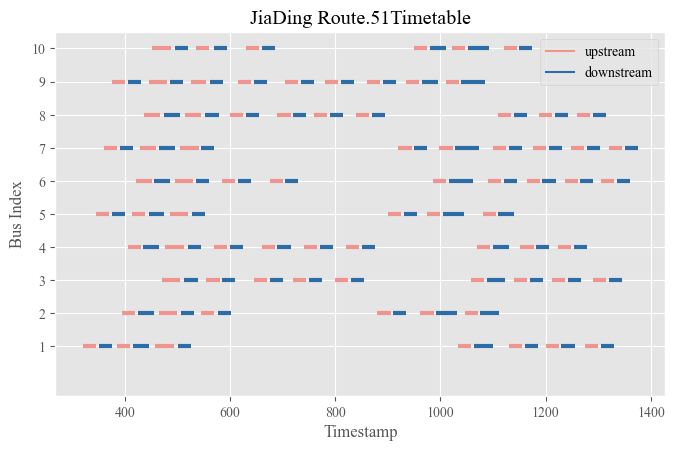

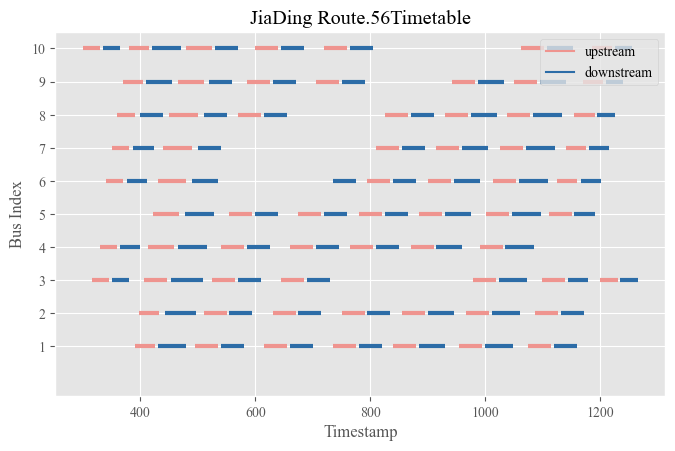

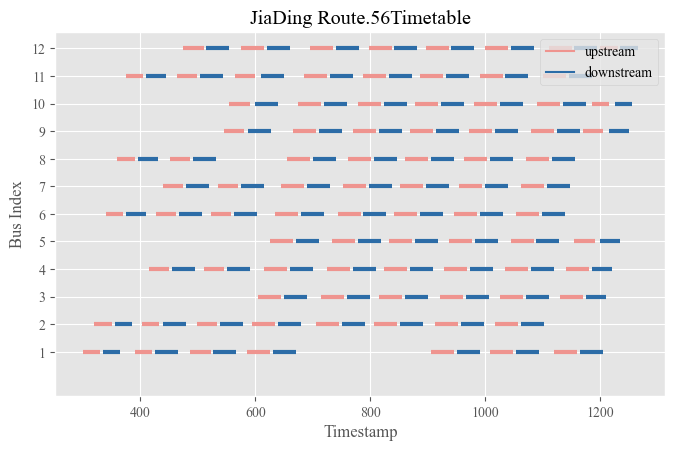

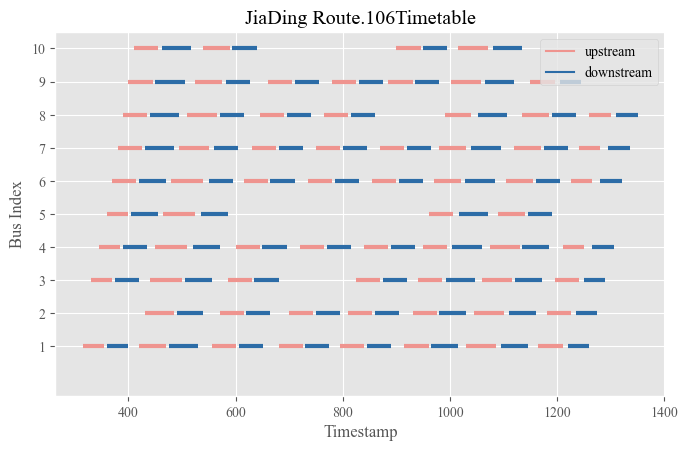

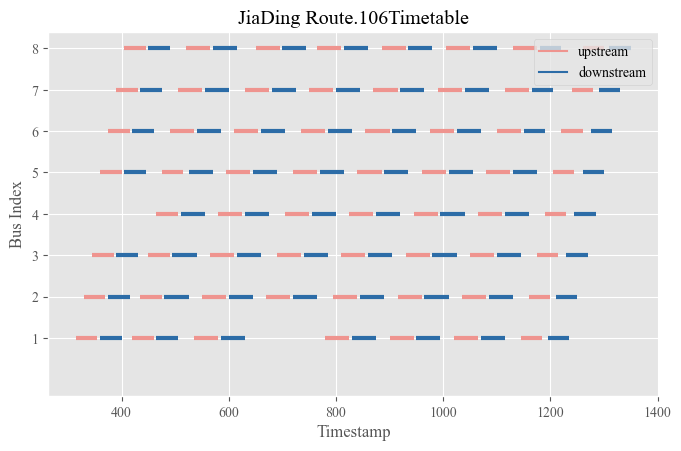

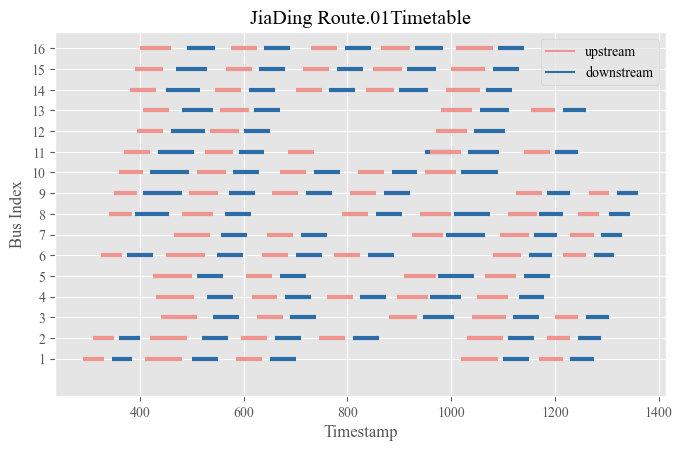

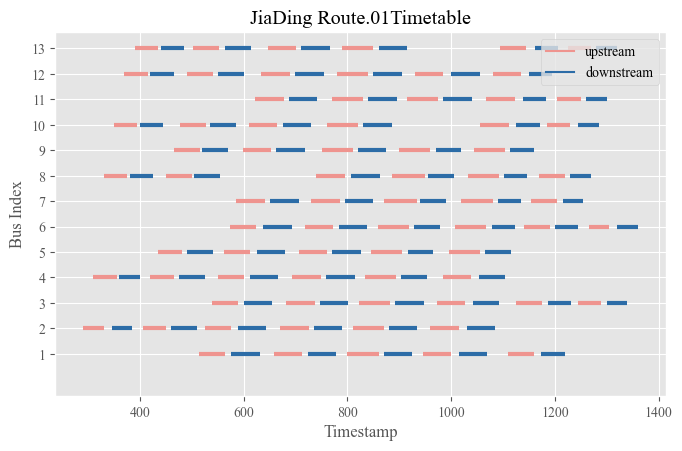

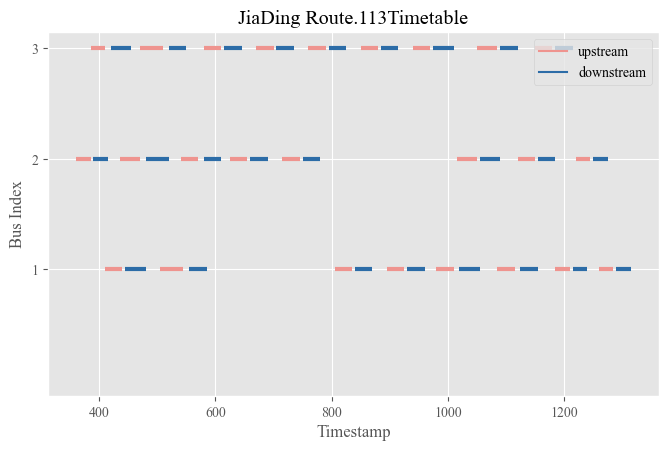

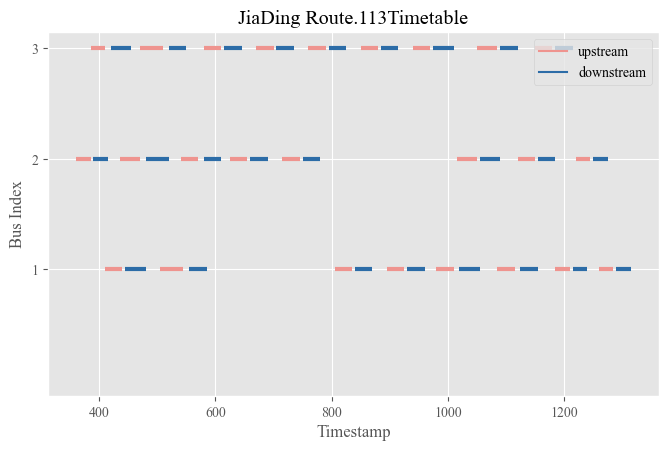

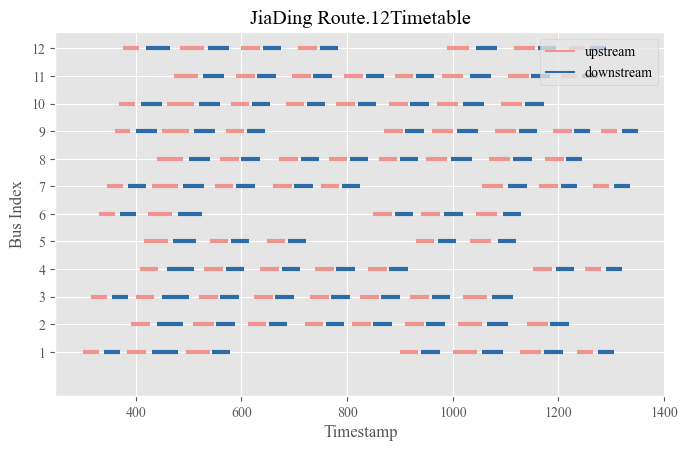

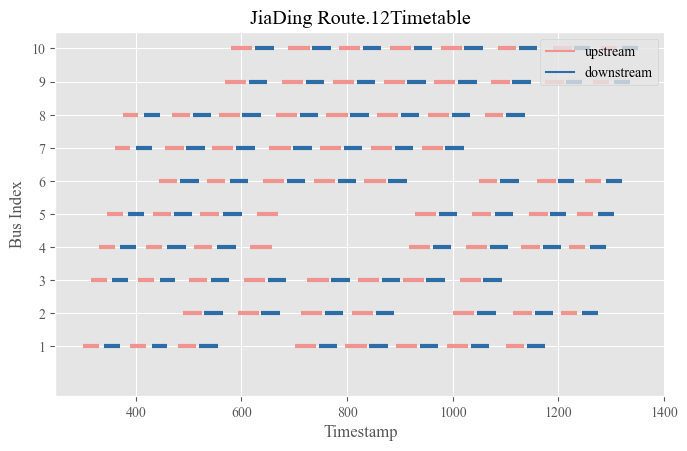

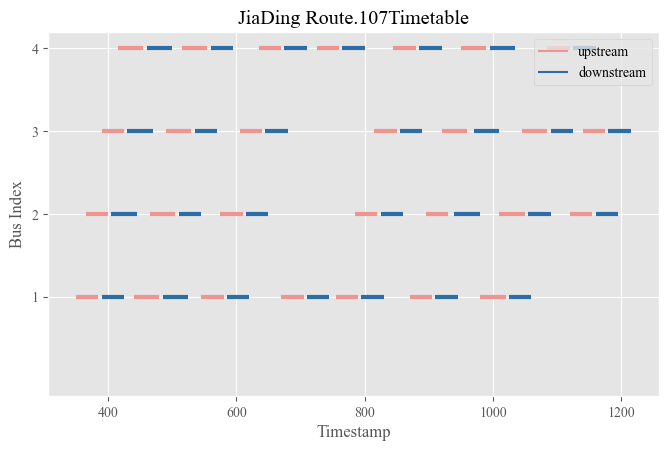

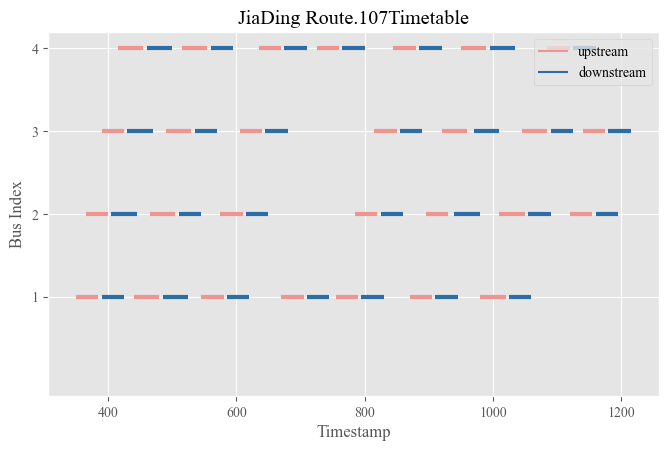

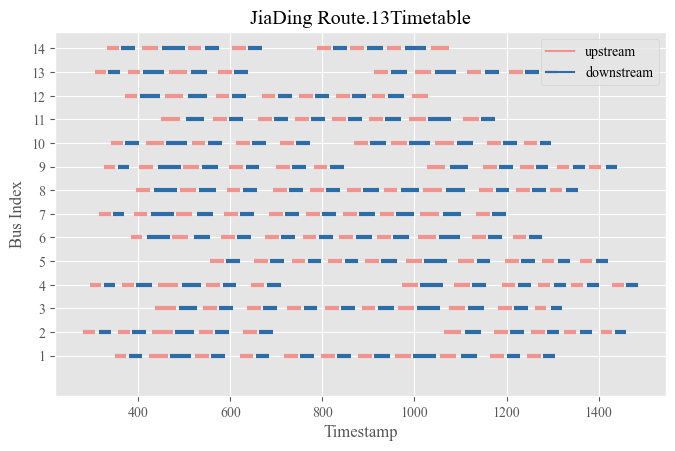

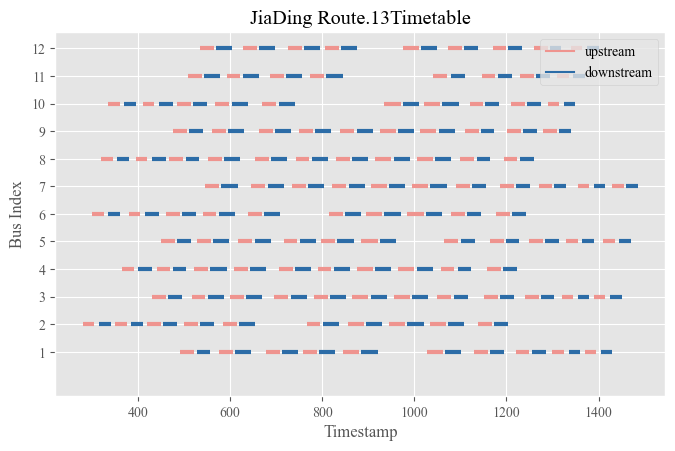

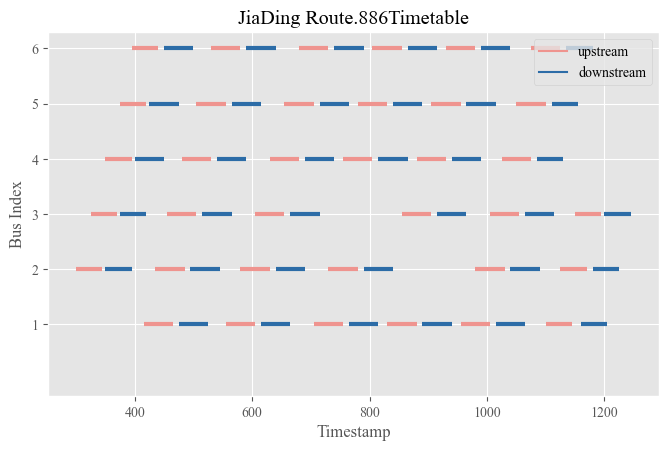

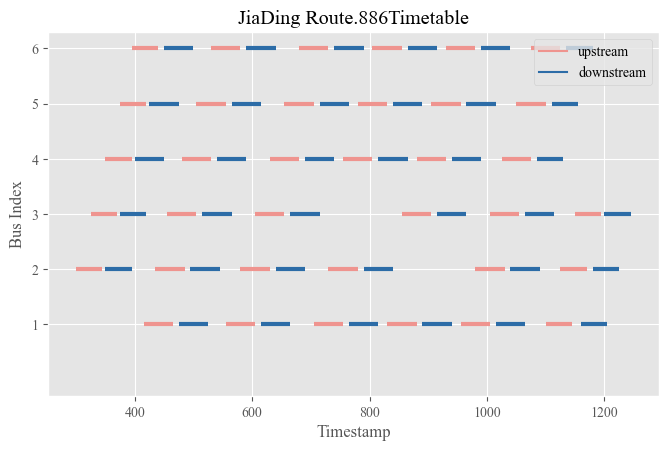

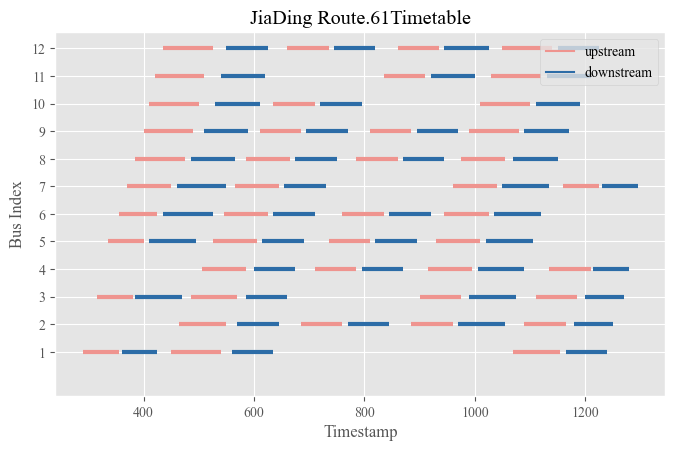

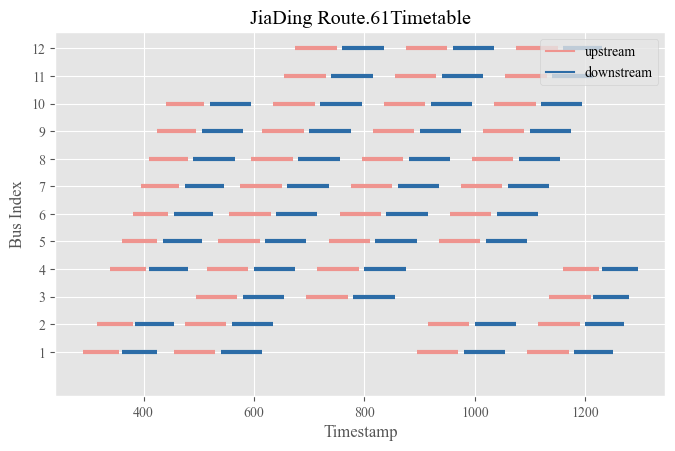

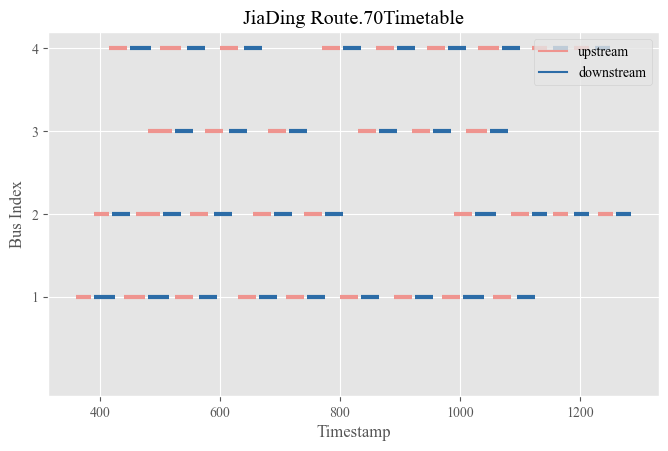

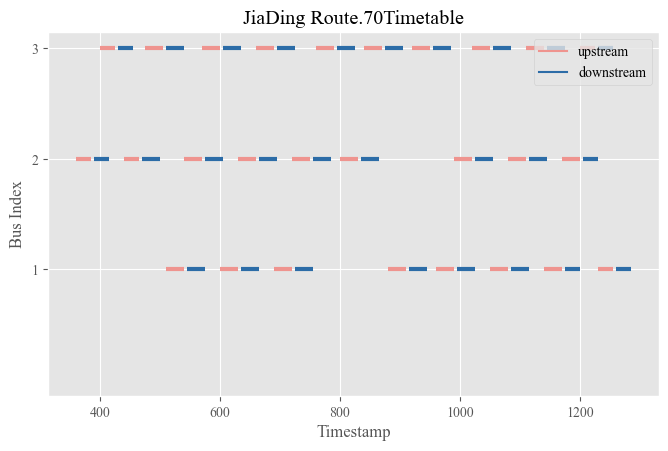

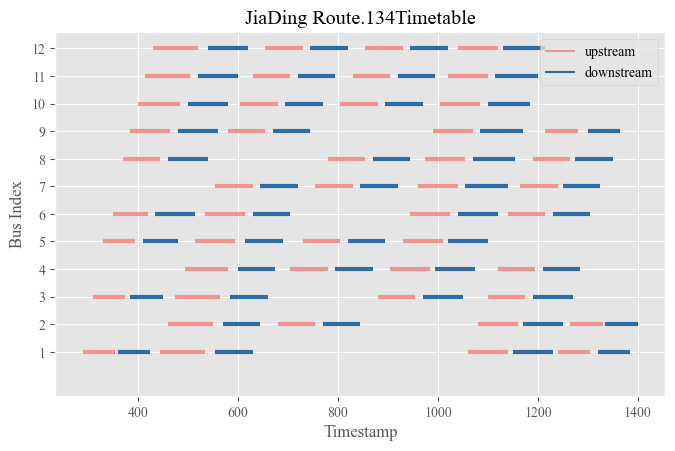

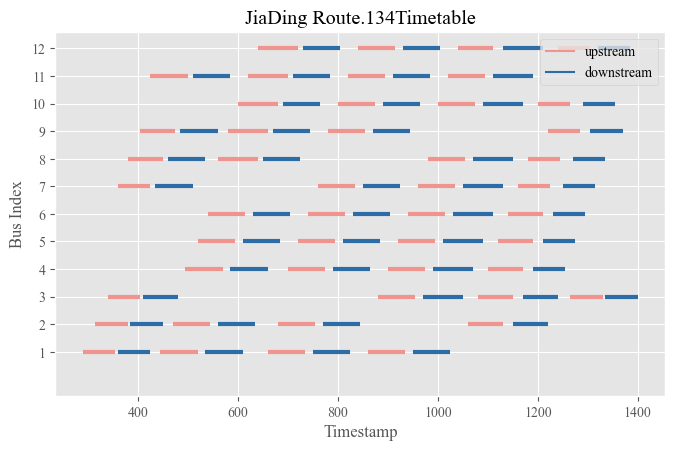

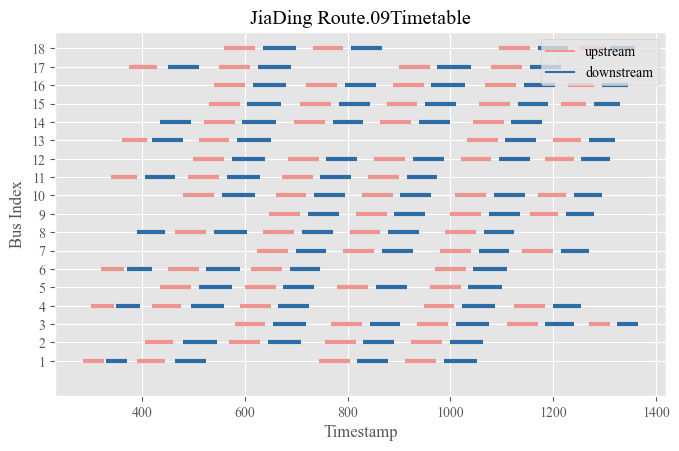

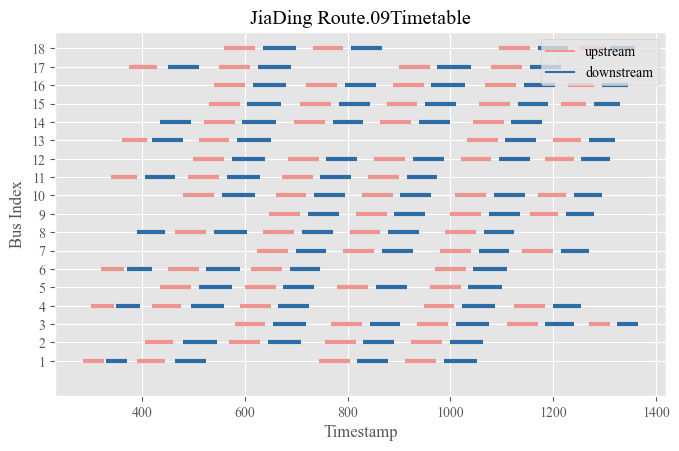

In [9]:
import re
def timetableArrayViewNew(timetableArray,turning_point,turning_time,title):
    '''
    timetableArray: [[[],[],[]],[[],[],[]]]
    对timetableArray进行可视化
    '''
    plt.figure(figsize=(200*mm,120*mm))
    max_index = 0
    plt.plot([500,500],[0,0],color='#EF948F',label='upstream')
    plt.plot([500,500],[0,0],color='#2C6CA7',label='downstream')
    meal_x = [600,12*60+30]
    meal_y1 = 0
    meal_y2 = len(timetableArray)+1
    # plt.fill_between(meal_x,meal_y1,meal_y2,alpha=0.25)
    plt.legend()
    for index in timetableArray:
        for bus in index:
            c = ['#EF948F','#2C6CA7']
            plt.hlines(y=bus[2], xmin=bus[0], xmax=bus[0] +get_moment_direction(turning_point,turning_time,bus[0], bus[1]), colors=c[bus[1]],linewidth=3)
            max_index = max(max_index, bus[2])
    plt.yticks(list(range(1, max_index + 1)))
    plt.ylabel('Bus Index')
    plt.xlabel('Timestamp')
    plt.title(title)

for key in dataset:
    timetableChain,runningTimeArray=reshapeTimeTable(dataset[key])
    timetableArray,trips,headway=formatTimetaleArray(timetableChain,runningTimeArray)
    runningPoint,runningTime=formatTurnningTime(trips)
    num = re.findall(r'\d+',key)
    if not num:
        num.append('0')
    timetableArrayViewNew(timetableArray,runningPoint,runningTime,'JiaDing Route.'+num[0]+'Timetable')
    plt.savefig('../../output/real_timetable/'+key+'.pdf',dpi=600,bbox_inches='tight') 

In [10]:
def workmodeTimeFromTimetableChain(timetableChain,runningPoint,runningTime):
    ''' 
    获取司机两头班的开始时间和结束时间

    input:
    timetableChain: 原始时刻表解析的dataframe格式,填充-1下班 -2上班 -3两头班
    runningPoint: 获取周转时间的时间点
    runningTime: 获取周转时间的具体时间

    return:
    workmodeList: 工作模式的清单
    '''
    workmodeList=[]
    for i in range(1,len(timetableChain)):
        workmode=[]
        flag=1
        for j in range(len(timetableChain.iloc[i,:])):
            # 对于每一行
            if timetableChain.iloc[i,j]==-3 and flag==1:
                workmode.append(datetime2int(timetableChain.iloc[i,j-1])+get_moment_direction(runningPoint,runningTime,datetime2int(timetableChain.iloc[i,j-1]),1))
                flag=0
            if timetableChain.iloc[i,j]!=-3 and flag==0:
                workmode.append(datetime2int(timetableChain.iloc[i,j]))
                flag=1
        if workmode:
            workmodeList.append(copy.deepcopy(workmode))
    return workmodeList

def HRMDfromTimetableNew(timetableDF):
    ''' 
    从结构的timetable数据文件夹中进行分析,返回 车次链、发车间隔节点、发车间隔时间、周转时间间隔、周转时间节点
    就餐时长、就餐次数统计、工作模式、工作模式计数

    input:
    timetableDF:解析之后的pandas.dataframe格式的timetableDF

    output:
    res.timetableChain
    res.headwayPoint
    res.headwayTime
    res.runningPoint
    res.runningTime
    res.mealInterval
    res.mealCount
    res.workmodelInterval
    res.workmodeCount
    '''
    # 返回新的timetable 和runningTimeArray 的解析
    timetableChain,runningTimeArray=reshapeTimeTable(timetableDF)
    # 由此得到departure time
    timetableArray,departureTime,headway=formatTimetaleArray(timetableChain,runningTimeArray)

    # 由此得到running和headway
    runningPoint,runningTime=formatTurnningTime(departureTime)
    headwayPoint,headwayTime=departureTime2Headway(departureTime)

    # meal time
    mealTimeList=[]
    for driver in timetableArray:
        meal_time=[]
        for i in range(len(driver)-1):
            if driver[i+1][0]-driver[i][0] > 30+get_moment_direction(runningPoint,runningTime,driver[i][0],driver[i][1]):
                # 选用前面的时间点
                meal_time.append(driver[i][0]+get_moment_direction(runningPoint,runningTime,driver[i][0],driver[i][1])+10)
                meal_time.append(meal_time[-1]+25)
                break
        mealTimeList.append(copy.deepcopy(meal_time))
    mealInterval,mealCount=countListTime(mealTimeList=mealTimeList)
    print(mealTimeList)
    timetableChain=timetableChainFill(timetableChain)
    workmodeList=workmodeTimeFromTimetableChain(timetableChain,runningPoint,runningTime)
    print(workmodeList)
    workmodeInterval,workmodeCount=countListTime(mealTimeList=workmodeList)

    featureList = []
    for driver in timetableArray:
        for bus in driver:
            curr = copy.deepcopy(bus)

            # 添加班次的周转时间
            curr.append(get_moment_direction(runningPoint, runningTime, curr[0],curr[1]))

            #TODO 后续在添加虚拟班次
            # -1 下班、-2上班、-3两头班、0表示正常班次
            featureList.append(curr)

    columns = ['depature time','direction','index','running time']
    seqTimetable = pd.DataFrame(featureList,columns=columns)
    res={
        'timetableChain':timetableChain,
        'headwayPoint':headwayPoint,
        'headwayTime':headwayTime,
        'runningPoint':runningPoint,
        'runningTime':runningTime,
        'mealInterval':mealInterval,
        'mealCount':mealCount,
        'workmodeInterval':workmodeInterval,
        'workmodeCount':workmodeCount,
        'seqTimetable':seqTimetable
    }
    return res


## Rule fot worktime

In [11]:
# 工作时间分布

def get_moment_direction_new(point,time,moment,direction):
    """ 取阶梯形状的时间点

    Args:
    moment : 时间点
    direction : 方向，0代表上行、1代表下行

    Return:
    返回对应的时间点
    """
    for i in range(len(point[direction])):
        if moment<=point[direction][i]:
            return time[direction][i-1]

def adjustWorkTime(workTime):
    if workTime<420:
        # 做五休二
        res = workTime*20.63/60
    else:
        res = workTime*15/60
    return res


ArrayTotalDriverTime = []
ArrayTotalRestTime = []
for key in dataset:
    # 返回新的timetable 和runningTimeArray 的解析
    timetableChain,runningTimeArray=reshapeTimeTable(dataset[key])
    # 由此得到departure time
    timetableArray,departureTime,headway=formatTimetaleArray(timetableChain,runningTimeArray)
    runningPoint,runningTime=formatTurnningTime(departureTime)

    # 计算司机的工作时间
    ListDriverWorkTime = []
    RestDriverTime = []
    for driver_index in range(len(timetableArray)):
        workTime = 0
        restTime = 0
        for trip_index in range(len(timetableArray[driver_index])):
            workTime += get_moment_direction_new(runningPoint,runningTime,timetableArray[driver_index][trip_index][0],timetableArray[driver_index][trip_index][1])
            try:
                d = timetableArray[driver_index][trip_index+1][0]-timetableArray[driver_index][trip_index][0]-get_moment_direction_new(runningPoint,runningTime,timetableArray[driver_index][trip_index][0],timetableArray[driver_index][trip_index][1])
                if d <30:
                    restTime+=d           
            except:
                pass
        ListDriverWorkTime.append(workTime)
        RestDriverTime.append(restTime)
    ArrayTotalDriverTime.append(copy.deepcopy(ListDriverWorkTime))
    ArrayTotalRestTime.append(copy.deepcopy(RestDriverTime))

NameError: name 'diff_work_time' is not defined

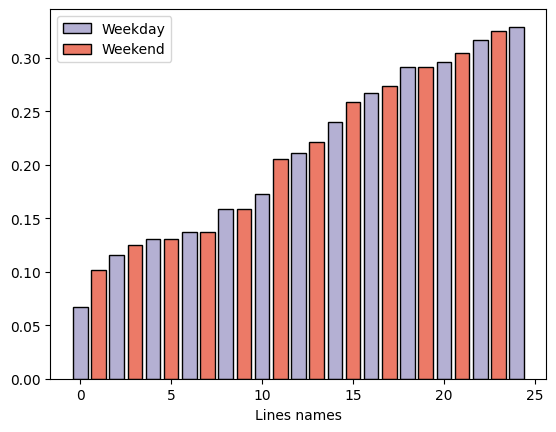

In [12]:
temp_ave = []
temp_pve_driver = []
for a in range(len(ArrayTotalRestTime)):
    res = np.sum(ArrayTotalRestTime[a])/np.sum(ArrayTotalDriverTime[a])
    if res > 0:
        temp_pve_driver.append(res)
    else:
        temp_pve_driver.append(0.15+np.random.randint(0,4)*0.01)

sorted_indices = np.argsort(temp_pve_driver)
# plt.bar(list(range(len(temp_ave))),temp_ave)
plt.style.use('default')
plt.xlabel('Lines names')
plt.bar(list(range(len(temp_pve_driver)))[::2],np.array(temp_pve_driver)[sorted_indices][::2],color='#B4B0D3',alpha=1,edgecolor='k',label='Weekday')
plt.bar(list(range(len(temp_pve_driver)))[1::2],np.array(temp_pve_driver)[sorted_indices][1::2],color='#EC7A67',alpha=1,edgecolor='k',label='Weekend')
plt.legend()
plt.xticks(ticks=list(range(0,len(diff_work_time),2)),labels=tempLabels[::2],rotation=90)
plt.ylabel('Average rest proportion')
plt.savefig('../../img/rules_restProgagation.pdf',dpi=600,bbox_inches='tight')    

<Figure size 669.291x393.701 with 0 Axes>

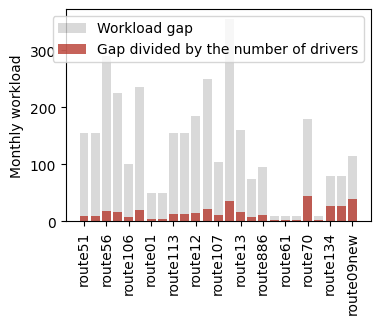

In [13]:
plt.style.use('default')
plt.figure(figsize=(170*mm,100*mm))
diff_work_time = []
diff_work_time_ave = []
Driver_num = []
for a in ArrayTotalDriverTime:
    diff_work_time.append(max(a) - min(a))
    Driver_num.append(len(a))
    diff_work_time_ave.append((max(a) - min(a))/len(a))

arry = np.array(Driver_num)
sorted_indices = np.argsort(arry)
plt.figure(figsize=(100*mm,70*mm))
plt.bar(list(range(len(diff_work_time))),np.array(diff_work_time)[sorted_indices[::-1]],color='k',alpha=0.15,label='Workload gap')
plt.bar(list(range(len(diff_work_time))),np.array(diff_work_time_ave)[sorted_indices[::-1]],color='#B42F23',label='Gap divided by the number of drivers',alpha=0.75)
tempLabels = [i.split('.')[0] for i in dataset.keys()]
plt.legend()
plt.xticks(ticks=list(range(0,len(diff_work_time),2)),labels=tempLabels[::2],rotation=90)
plt.ylabel('Monthly workload')
plt.savefig('../../img/rules_worktime.pdf',dpi=600,bbox_inches='tight')    


## Rule for headway

[[536, 561], [612, 637], [620, 645], [635, 660], [562, 587], [650, 675], [580, 605], [665, 690], [680, 705], [604, 629]]
[[526, 1034], [602, 880], [855, 1058], [875, 1070], [552, 900], [730, 986], [570, 920], [895, 1110], [685, 950]]
[[590, 615], [605, 630], [620, 645], [635, 660], [650, 675], [545, 570], [550, 575], [665, 690], [680, 705], [695, 720]]
[[730, 978], [535, 735], [540, 810], [655, 825], [790, 942], [805, 1062]]
route56.xlsxweekend
route106.xlsxweekday
route106.xlsxweekend
[[560, 585], [720, 745], [600, 625], [590, 615], [570, 595], [608, 633], [616, 641], [624, 649], [632, 657], [640, 665], [650, 675], [660, 685], [680, 705], [670, 695], [540, 565], [700, 725]]
[[700, 1020], [860, 1030], [740, 880], [720, 910], [890, 1080], [760, 925], [614, 790], [920, 1125], [735, 950], [650, 970], [670, 980]]
route01.xlsweekend
[[595, 620], [790, 815], [1020, 1045]]
[[585, 805], [780, 1015]]
[[595, 620], [790, 815], [1020, 1045]]
[[585, 805], [780, 1015]]
[[589, 614], [697, 722], [709,

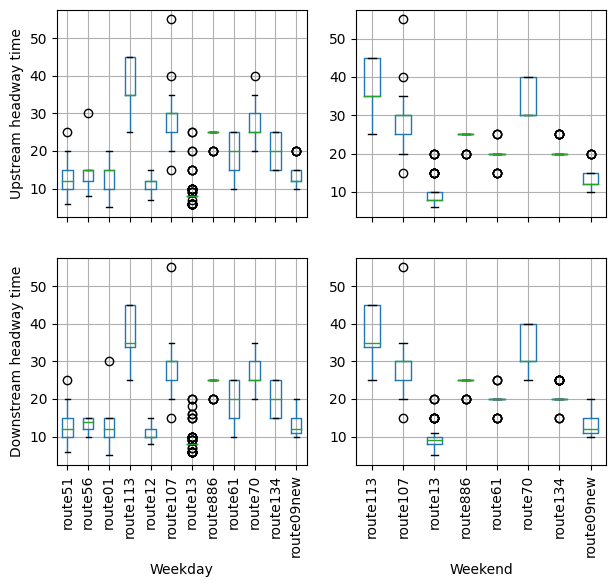

In [19]:
def adjustHeadwayTime(headway):
    """
    超出60的都可以认为是假的
    """
    mylist = [h for h in headway if h<=60]
    return mylist
# 行程时间分布有序
headwayListWeekdayUp = []
headwayListWeekdayDown = []
headwayLIstWeekendUp = []
headwayLIstWeekendDown = []
ListXtickLabels = [[] for _ in range(2)]
for key in dataset:
    try:
        res = HRMDfromTimetableNew(dataset[key])
        if 'weekday' in key:
            headwayListWeekdayUp.append(adjustHeadwayTime(res['headwayTime'][0]))
            ListXtickLabels[0].append(key.split('.')[0])
            headwayListWeekdayDown.append(adjustHeadwayTime(res['headwayTime'][1]))
        else:
            headwayLIstWeekendUp.append(adjustHeadwayTime(res['headwayTime'][0]))
            headwayLIstWeekendDown.append(adjustHeadwayTime(res['headwayTime'][1]))
            ListXtickLabels[1].append(key.split('.')[0])
    except:
        print(key)
plt.figure(figsize=(180*mm,150*mm))
plt.subplot(2,2,1)
df_headway = pd.DataFrame(headwayListWeekdayUp)
df_headway.T.boxplot()
# plt.xticks(ticks=list(range(1,len(ListXtickLabels[0])+1)),labels=ListXtickLabels[0],rotation=90)
plt.xticks(ticks=list(range(1,len(ListXtickLabels[0])+1)),labels = ['' for _ in range(len(ListXtickLabels[0]))])
plt.ylabel('Upstream headway time')

# plt.fill_between(list(range(1,len(ListXtickLabels[0])+1)),10,25,alpha=0.25)
# plt.xlabel('Weekday')

plt.subplot(2,2,3)
df_headway = pd.DataFrame(headwayListWeekdayDown)
df_headway.T.boxplot()
plt.xticks(ticks=list(range(1,len(ListXtickLabels[0])+1)),labels=ListXtickLabels[0],rotation=90)
# plt.xticks(ticks=list(range(1,len(ListXtickLabels[0])+1)),labels = ['' for _ in range(len(ListXtickLabels[0]))])
# plt.fill_between(list(range(1,len(ListXtickLabels[0])+1)),10,25,alpha=0.25)
plt.ylabel('Downstream headway time')
plt.xlabel('Weekday')

plt.subplot(2,2,2)
df_headway = pd.DataFrame(headwayLIstWeekendUp)
df_headway.T.boxplot()
# plt.xticks(ticks=list(range(1,len(ListXtickLabels[1])+1)),labels=ListXtickLabels[1],rotation=90)
plt.xticks(ticks=list(range(1,len(ListXtickLabels[1])+1)),labels = ['' for _ in range(len(ListXtickLabels[1]))])
# plt.fill_between(list(range(1,len(ListXtickLabels[1])+1)),10,35,alpha=0.25)
# plt.ylabel('Upstream headway time')
# plt.xlabel('Weekend')

plt.subplot(2,2,4)
df_headway = pd.DataFrame(headwayLIstWeekendDown)
df_headway.T.boxplot()
plt.xticks(ticks=list(range(1,len(ListXtickLabels[1])+1)),labels=ListXtickLabels[1],rotation=90)
# plt.fill_between(list(range(1,len(ListXtickLabels[1])+1)),10,35,alpha=0.25)
# plt.ylabel('Downstreamheadway time')
plt.xlabel('Weekend')

plt.savefig('../../img/rules_headway.pdf',dpi=600,bbox_inches='tight')    

## Rule for layover time

In [20]:
# 主站休息时间和副站休息时间的分布
main_breaktime = []
sub_breaktime = []
for key in dataset:
    timetableChain,runningTimeArray=reshapeTimeTable(dataset[key])
    timetableArray,trips,headway=formatTimetaleArray(timetableChain,runningTimeArray)
    runningPoint,runningTime=formatTurnningTime(trips)
    for i in range(len(timetableArray)):
        for j in range(len(timetableArray[i])-1):
            if timetableArray[i][j][1] == 1:
                main_breaktime.append(timetableArray[i][j+1][0] - timetableArray[i][j][0]-get_moment_direction_new(runningPoint,runningTime,timetableArray[i][j][0],timetableArray[i][j][1]))
            elif timetableArray[i][j][1] == 0:
                sub_breaktime.append(timetableArray[i][j+1][0] - timetableArray[i][j][0]-get_moment_direction_new(runningPoint,runningTime,timetableArray[i][j][0],timetableArray[i][j][1]))
    

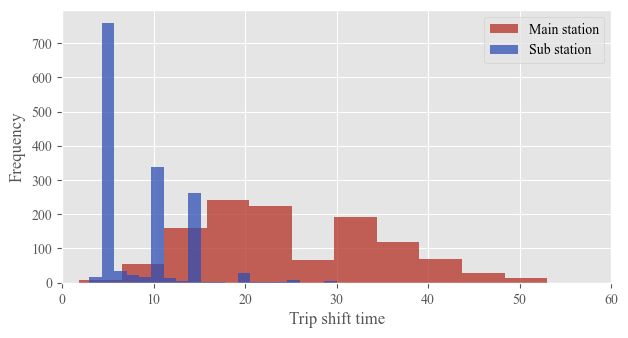

In [21]:
import seaborn as sns
plt.style.use('ggplot')
main_breaktime = [i for i in main_breaktime if i<=60]
sub_breaktime = [i for i in sub_breaktime if i<=60]
plt.rcParams['font.family']= "Times New Roman"
plt.figure(figsize=(180*mm,90*mm))
plt.xlim(0,60)
plt.xlabel('Trip shift time')
plt.ylabel('Frequency')
plt.hist(main_breaktime,bins=20,color='#B42F23',label='Main station',alpha=0.75)
plt.hist(sub_breaktime,bins=20,color='#2F4FB4',label='Sub station',alpha=0.75)
plt.legend()
plt.savefig('../../output/rule_tripshift.pdf',dpi=600,bbox_inches='tight')

## Rule for meal time windows

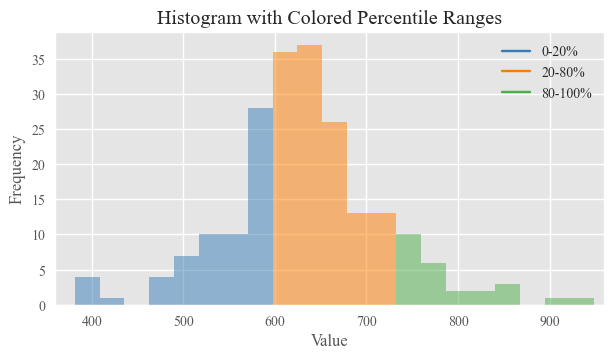

In [120]:
mealtime = []
for key in dataset:
    timetableChain,runningTimeArray=reshapeTimeTable(dataset[key])
    timetableArray,trips,headway=formatTimetaleArray(timetableChain,runningTimeArray)
    runningPoint,runningTime=formatTurnningTime(trips)
    for i in range(len(timetableArray)):
        for j in range(len(timetableArray[i])-1):
            if timetableArray[i][j+1][0] - timetableArray[i][j][0]-get_moment_direction_new(runningPoint,runningTime,timetableArray[i][j][0],timetableArray[i][j][1])>30:
                mealtime.append(timetableArray[i][j][0]+get_moment_direction_new(runningPoint,runningTime,timetableArray[i][j][0],timetableArray[i][j][1]))
                break
plt.figure(figsize=(180*mm,90*mm))
plt.rcParams['font.family']= "Times New Roman"
plt.xlim(360,16*60)
plt.xlabel('Time of day')
plt.ylabel('Frequency')

data = mealtime
# Define the percentile ranges we're interested in
percentile_ranges = [(0, 20), (20, 80), (80, 100)]

# Calculate the values at these percentile ranges
values_at_percentile_ranges = [(np.percentile(data, low), np.percentile(data, high)) for low, high in percentile_ranges]

# Get the histogram data
counts, bin_edges = np.histogram(data, bins=30)

# Create an array for the colors, defaulting to gray
colors = ['gray'] * len(bin_edges)

# Define colors for each percentile range
range_colors = ['#377eb8', '#ff7f00', '#4daf4a']

for (low, high), color in zip(values_at_percentile_ranges, range_colors):
    # Change the color of the bins within the percentile ranges to different colors
    for bin_index in range(len(bin_edges)):
        if low <= bin_edges[bin_index] < high:
            colors[bin_index] = color

# Now, let's plot the histogram with the colored bins.
plt.bar(bin_edges[:-1], counts, color=colors, alpha=0.5, width=np.diff(bin_edges))

# Add labels for the percentile ranges
for (low_percentile, high_percentile), color in zip(percentile_ranges, range_colors):
    plt.plot([], [], label=f'{low_percentile}-{high_percentile}%', color=color)

plt.title('Histogram with Colored Percentile Ranges')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.savefig('../../output/rule_mealtime.pdf',dpi=600,bbox_inches='tight')

# plt.hist(mealtime,bins=48,color='#B42F23',alpha=0.75)

In [127]:
# 选取56路作为对照
target = 'route56.xlsxweekend'
timetableChain,runningTimeArray = reshapeTimeTable(dataset[target])
timetableArray,trips,headway = formatTimetaleArray(timetableChain,runningTimeArray)
runningPoint,runningTime = formatTurnningTime(trips)

In [129]:
runningPoint

[[0, 360, 398, 406, 422, 450, 480, 1110, 1185, 2000],
 [0,
  350,
  388,
  399,
  410,
  430,
  454,
  478,
  490,
  870,
  987,
  1083,
  1107,
  1131,
  1180,
  2000]]